# Import Essential Libraries 

In [ ]:
import os, json, math, joblib, requests
from pathlib import Path
import pandas as pd
import numpy as np
from numpy._core.defchararray import upper
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, f_regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Step 6: Feature Engineering
## 6.1 Outlier analysis

In [2]:
# One line to rule them all
df_final = pd.read_parquet('../data/processed/df_final_checkpoint.parquet')
print(f"Resumed! Dataset shape: {df_final.shape}")

Resumed! Dataset shape: (180519, 28)


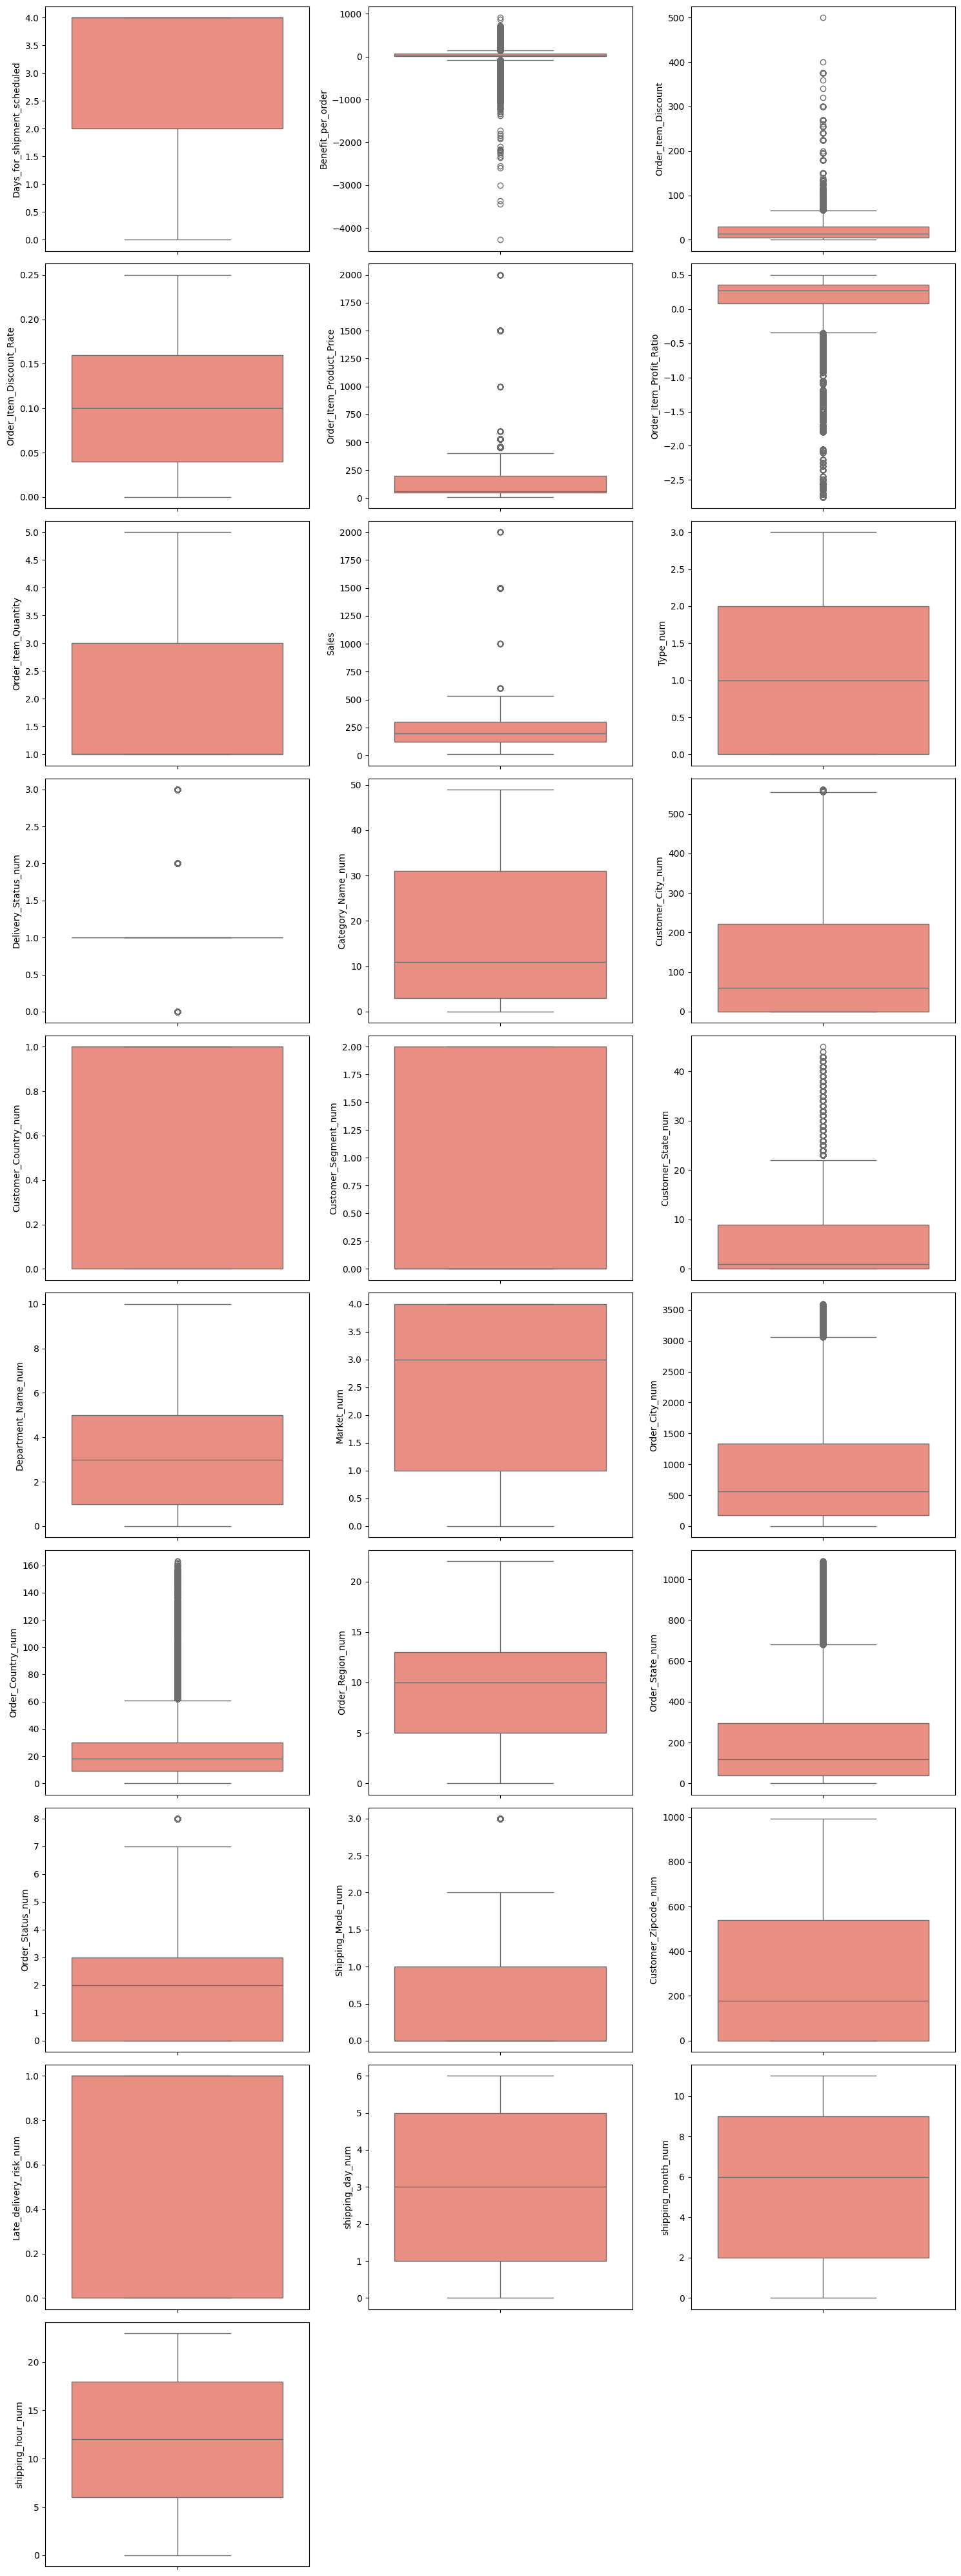

In [5]:
# Creating boxplot to understand the outliers in each variable
ncols = 3
nrows = math.ceil(len(df_final.columns.tolist()) / ncols)
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (15, 4 * nrows))

axes = axes.flatten()
for i, col in enumerate(df_final.columns.tolist()):
    sns.boxplot(data= df_final, y= col, ax= axes[i], color= 'salmon')
for j in range(len(df_final.columns.tolist()), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 6.1.1 Conclusion Boxplots Charts
-------- TBC -------------------------

In [13]:
# Necessary coding to replace outliers creating upper and lower limits
df_WITH_outliers = df_final.copy()
df_WITHOUT_outliers = df_final.copy()

# Defineing the columns to be treated for outliers.
outliers_cols = ['Benefit_per_order','Order_Item_Discount','Order_Item_Product_Price', 'Order_Item_Profit_Ratio',
                 'Sales','Delivery_Status_num','Customer_City_num','Customer_State_num','Order_City_num',
                 'Order_Country_num','Order_State_num','Order_Status_num','Shipping_Mode_num',] # The target variable price can't be modified so we leave as it is.

def replace_outliers(column, data_df):
   col_stats = data_df[column].describe()
   col_iqr = col_stats["75%"] - col_stats["25%"]
   upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
   lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

   if lower_limit < 0: lower_limit = min(data_df[column])
   # Let's take out upper outliers 
   data_df[column] = data_df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
   # Let's take out lower outliers 
   data_df[column] = data_df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
   return data_df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in outliers_cols:
   df_WITHOUT_outliers, limits = replace_outliers(column, df_WITHOUT_outliers)
   outliers_dict.update({column: limits})

print(f"Limits using base columns: {outliers_dict}") # This jason needs to be saved for future reference. We will use it to replace outliers in the test set and in production.

Limits using base columns: {'Benefit_per_order': [-4274.97998, 151.5], 'Order_Item_Discount': [0.0, 66.87], 'Order_Item_Product_Price': [9.989999771, 424.98], 'Order_Item_Profit_Ratio': [-2.75, 0.78], 'Sales': [9.989999771, 569.91], 'Delivery_Status_num': [1.0, 1.0], 'Customer_City_num': [0, 555.0], 'Customer_State_num': [0, 22.5], 'Order_City_num': [0, 3064.5], 'Order_Country_num': [0, 61.5], 'Order_State_num': [0, 680.0], 'Order_Status_num': [0, 7.5], 'Shipping_Mode_num': [0, 2.5]}


In [14]:
# Saving the json dictionary for outliers limit
with open('../data/interim/outliers_dict.json', 'w') as f:
     json.dump(outliers_dict, f)

## 6.2 Missing Value Analysis

In [15]:
print("The list below, will show if dataset WITH outliers has any null value for the variables:")
print(df_WITH_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITH outliers has any null value for the variables:
Days_for_shipment_scheduled    0
Benefit_per_order              0
Order_Item_Discount            0
Order_Item_Discount_Rate       0
Order_Item_Product_Price       0
Order_Item_Profit_Ratio        0
Order_Item_Quantity            0
Sales                          0
Type_num                       0
Delivery_Status_num            0
Category_Name_num              0
Customer_City_num              0
Customer_Country_num           0
Customer_Segment_num           0
Customer_State_num             0
Department_Name_num            0
Market_num                     0
Order_City_num                 0
Order_Country_num              0
Order_Region_num               0
Order_State_num                0
Order_Status_num               0
Shipping_Mode_num              0
Customer_Zipcode_num           0
Late_delivery_risk_num         0
shipping_day_num               0
shipping_month_num             0
shipping_hour_num   

In [16]:
print("The list below, will show if dataset WITHOUT outliers has any null value for the variables:")
print(df_WITHOUT_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITHOUT outliers has any null value for the variables:
Days_for_shipment_scheduled    0
Benefit_per_order              0
Order_Item_Discount            0
Order_Item_Discount_Rate       0
Order_Item_Product_Price       0
Order_Item_Profit_Ratio        0
Order_Item_Quantity            0
Sales                          0
Type_num                       0
Delivery_Status_num            0
Category_Name_num              0
Customer_City_num              0
Customer_Country_num           0
Customer_Segment_num           0
Customer_State_num             0
Department_Name_num            0
Market_num                     0
Order_City_num                 0
Order_Country_num              0
Order_Region_num               0
Order_State_num                0
Order_Status_num               0
Shipping_Mode_num              0
Customer_Zipcode_num           0
Late_delivery_risk_num         0
shipping_day_num               0
shipping_month_num             0
shipping_hour_num

## 6.3 Inference of New Features
------------ EXPLAIN WHY WE DO IT ------------------

In [ ]:
def apply_engineering(df_input, is_base= True):
    
    # Applied to both sets
    df_input['total_acidity'] = df_input['fixed acidity'] + df_input['volatile acidity'] + df_input['citric acid']
    
    return df_input

# Generate the new experimental sets
df_WITH_outliers_baseCol = apply_engineering(df_WITH_outliers_baseCol, is_base=True)
df_WITHOUT_outliers_baseCol = apply_engineering(df_WITHOUT_outliers_baseCol, is_base=True)

df_WITH_outliers_optCol = apply_engineering(df_WITH_outliers_optCol, is_base=False)
df_WITHOUT_outliers_optCol = apply_engineering(df_WITHOUT_outliers_optCol, is_base=False)

In [ ]:
# Creating << NEW >> heatmap chart to analyze complete variables correlation
cols_num = df_WITH_outliers_baseCol.select_dtypes(include= ['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df_WITH_outliers_baseCol[cols_num].corr(method= "pearson"), annot= True, fmt= ".2f", cmap= "coolwarm", ax= ax).tick_params(axis= 'x', rotation= 45)
plt.tight_layout()
plt.show()

### 6.3.1 Conclusion on New Features
1. The "Total Acidity" Stability
- total_acidity feature shows a strong $1.00$ correlation with fixed acidity and $0.69$ with citric acid.
    - The Strategy: This confirms that I can safely drop the three individual acid columns.

* **Given the conclusion above**,
    - **FINAL_COL_DATSET_BASE** = [total_acidity, residual sugar, total sulfur dioxide, chlorides, sulphates, alcohol, pH, density, quality_bin]
    - **FINAL_COL_DATSET_OPT** = [total_acidity, total sulfur dioxide, chlorides, sulphates, alcohol, quality_bin]

In [ ]:
FINAL_COL_DATSET_BASE = ['total_acidity', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'sulphates', 'alcohol', 'pH', 'density', 'quality_bin']
FINAL_COL_DATSET_OPT = ['total_acidity', 'total sulfur dioxide', 'chlorides', 'sulphates', 'alcohol', 'quality_bin']

df_WITH_outliers_baseCol = df_WITH_outliers_baseCol[FINAL_COL_DATSET_BASE]
df_WITHOUT_outliers_baseCol = df_WITHOUT_outliers_baseCol[FINAL_COL_DATSET_BASE]
df_WITH_outliers_optCol = df_WITH_outliers_optCol[FINAL_COL_DATSET_OPT]
df_WITHOUT_outliers_optCol = df_WITHOUT_outliers_optCol[FINAL_COL_DATSET_OPT]



## 6.4 Feature Scaling

In [ ]:
# Divide the set into train and test
				
predictors_base = ['total_acidity', 'residual sugar', 'total sulfur dioxide', 'chlorides', 'sulphates', 'alcohol', 'pH', 'density']
predictors_opt = ['total_acidity', 'total sulfur dioxide', 'chlorides', 'sulphates', 'alcohol']
target = 'quality_bin'

X_WITH_outliers_baseCol = df_WITH_outliers_baseCol.drop(target, axis = 1)[predictors_base]
X_WITHOUT_outliers_baseCol = df_WITHOUT_outliers_baseCol.drop(target, axis = 1)[predictors_base]
X_WITH_outliers_optCol = df_WITH_outliers_optCol.drop(target, axis= 1)[predictors_opt]
X_WITHOUT_outliers_optCol = df_WITHOUT_outliers_optCol.drop(target, axis= 1)[predictors_opt]
y = df_WITH_outliers_baseCol[target]

X_train_WITH_outliers_baseCol, X_test_WITH_outliers_baseCol, y_train, y_test = train_test_split(X_WITH_outliers_baseCol, y, test_size = 0.2, random_state = 10)
X_train_WITHOUT_outliers_baseCol, X_test_WITHOUT_outliers_baseCol = train_test_split(X_WITHOUT_outliers_baseCol, test_size = 0.2, random_state = 10)
X_train_WITH_outliers_optCol, X_test_WITH_outliers_optCol, y_train, y_test = train_test_split(X_WITH_outliers_optCol, y, test_size = 0.2, random_state = 10)
X_train_WITHOUT_outliers_optCol, X_test_WITHOUT_outliers_optCol = train_test_split(X_WITHOUT_outliers_optCol, test_size = 0.2, random_state = 10)

In [ ]:
# Normalization and MIN_MAX Scaling
# X_train_WITH_outliers_baseCol 
# X_train_WITHOUT_outliers_baseCol 
# X_train_WITH_outliers_optCol
# X_train_WITHOUT_outliers_optCol

# WE NEED TO SAVE 3 OCCURRENCE: 1) DATASET PLANE (WITH NO CHANGES), 2) DATASET NORMALIZED, 3) DATASET MIN-MAX

## NORMALIZATION
### WITH OUTLIERS
# Base Columns
norm_WITH_outliers_baseCol = StandardScaler() # StandardScaler(), used to "normalize" or "resize" your data so that all your features are on the same scale.
# .fit(), The "Learning"
norm_WITH_outliers_baseCol.fit(X_train_WITH_outliers_baseCol) # Phase. the scaler (or model) looks at your data and calculates the necessary parameters. It does not change the data; it only learns from it.
# Opt. Columns
norm_WITH_outliers_optCol = StandardScaler()
norm_WITH_outliers_optCol.fit(X_train_WITH_outliers_optCol)

# .transform(), The "Applying" Phase.
# NOTE: .fit_transform() — The "Shortcut" --> This is simply a convenience method that does both steps at the same time on the same piece of data. --- Use this on your Training Data ---
# Base Columns
X_train_WITH_outliers_baseCol_norm = norm_WITH_outliers_baseCol.transform(X_train_WITH_outliers_baseCol) # This uses the parameters calculated during .fit() to actually modify the data.
X_train_WITH_outliers_baseCol_norm = pd.DataFrame(X_train_WITH_outliers_baseCol_norm, index = X_train_WITH_outliers_baseCol.index, columns = predictors_base) # We need to convert to DataFrame the transform with this variable
X_test_WITH_outliers_baseCol_norm = norm_WITH_outliers_baseCol.transform(X_test_WITH_outliers_baseCol)
X_test_WITH_outliers_baseCol_norm = pd.DataFrame(X_test_WITH_outliers_baseCol_norm, index = X_test_WITH_outliers_baseCol.index, columns = predictors_base)
# Opt. Columns
X_train_WITH_outliers_optCol_norm = norm_WITH_outliers_optCol.transform(X_train_WITH_outliers_optCol)
X_train_WITH_outliers_optCol_norm = pd.DataFrame(X_train_WITH_outliers_optCol_norm, index = X_train_WITH_outliers_optCol.index, columns = predictors_opt)
X_test_WITH_outliers_optCol_norm = norm_WITH_outliers_optCol.transform(X_test_WITH_outliers_optCol)
X_test_WITH_outliers_optCol_norm = pd.DataFrame(X_test_WITH_outliers_optCol_norm, index = X_test_WITH_outliers_optCol.index, columns = predictors_opt)

### WITHOUT OUTLIERS
# Base Columns
norm_WITHOUT_outliers_baseCol = StandardScaler()
norm_WITHOUT_outliers_baseCol.fit(X_train_WITHOUT_outliers_baseCol)
# Opt. Columns
norm_WITHOUT_outliers_optCol = StandardScaler()
norm_WITHOUT_outliers_optCol.fit(X_train_WITHOUT_outliers_optCol)
# Base Columns
X_train_WITHOUT_outliers_baseCol_norm = norm_WITHOUT_outliers_baseCol.transform(X_train_WITHOUT_outliers_baseCol)
X_train_WITHOUT_outliers_baseCol_norm = pd.DataFrame(X_train_WITHOUT_outliers_baseCol_norm, index = X_train_WITHOUT_outliers_baseCol.index, columns = predictors_base)
X_test_WITHOUT_outliers_baseCol_norm = norm_WITHOUT_outliers_baseCol.transform(X_test_WITHOUT_outliers_baseCol)
X_test_WITHOUT_outliers_baseCol_norm = pd.DataFrame(X_test_WITHOUT_outliers_baseCol_norm, index = X_test_WITHOUT_outliers_baseCol.index, columns = predictors_base)
# Opt. Columns
X_train_WITHOUT_outliers_optCol_norm = norm_WITHOUT_outliers_optCol.transform(X_train_WITHOUT_outliers_optCol)
X_train_WITHOUT_outliers_optCol_norm = pd.DataFrame(X_train_WITHOUT_outliers_optCol_norm, index = X_train_WITHOUT_outliers_optCol.index, columns = predictors_opt)
X_test_WITHOUT_outliers_optCol_norm = norm_WITHOUT_outliers_optCol.transform(X_test_WITHOUT_outliers_optCol)
X_test_WITHOUT_outliers_optCol_norm = pd.DataFrame(X_test_WITHOUT_outliers_optCol_norm, index = X_test_WITHOUT_outliers_optCol.index, columns = predictors_opt)


## SCALED MIN_MAX
### WITH OUTLIERS
# Base Columns
scaler_WITH_outliers_baseCol = MinMaxScaler() # MinMaxScaler() is a scaling technique that transforms the data so that all values fall within a specific range, most commonly between 0 and 1.
scaler_WITH_outliers_baseCol.fit(X_train_WITH_outliers_baseCol)
# Opt. Columns
scaler_WITH_outliers_optCol = MinMaxScaler() # MinMaxScaler() is a scaling technique that transforms the data so that all values fall within a specific range, most commonly between 0 and 1.
scaler_WITH_outliers_optCol.fit(X_train_WITH_outliers_optCol)
# Base Columns
X_train_WITH_outliers_baseCol_scal = scaler_WITH_outliers_baseCol.transform(X_train_WITH_outliers_baseCol)
X_train_WITH_outliers_baseCol_scal = pd.DataFrame(X_train_WITH_outliers_baseCol_scal, index = X_train_WITH_outliers_baseCol.index, columns = predictors_base)
X_test_WITH_outliers_baseCol_scal = scaler_WITH_outliers_baseCol.transform(X_test_WITH_outliers_baseCol)
X_test_WITH_outliers_baseCol_scal = pd.DataFrame(X_test_WITH_outliers_baseCol_scal, index = X_test_WITH_outliers_baseCol.index, columns = predictors_base)
# Opt. Columns
X_train_WITH_outliers_optCol_scal = scaler_WITH_outliers_optCol.transform(X_train_WITH_outliers_optCol)
X_train_WITH_outliers_optCol_scal = pd.DataFrame(X_train_WITH_outliers_optCol_scal, index = X_train_WITH_outliers_optCol.index, columns = predictors_opt)
X_test_WITH_outliers_optCol_scal = scaler_WITH_outliers_optCol.transform(X_test_WITH_outliers_optCol)
X_test_WITH_outliers_optCol_scal = pd.DataFrame(X_test_WITH_outliers_optCol_scal, index = X_test_WITH_outliers_optCol.index, columns = predictors_opt)

### WITHOUT OUTLIERS
# Base Columns
scaler_WITHOUT_outliers_baseCol = MinMaxScaler()
scaler_WITHOUT_outliers_baseCol.fit(X_train_WITHOUT_outliers_baseCol)
# Opt. Columns
scaler_WITHOUT_outliers_optCol = MinMaxScaler()
scaler_WITHOUT_outliers_optCol.fit(X_train_WITHOUT_outliers_optCol)
# Base Columns
X_train_WITHOUT_outliers_baseCol_scal = scaler_WITHOUT_outliers_baseCol.transform(X_train_WITHOUT_outliers_baseCol)
X_train_WITHOUT_outliers_baseCol_scal = pd.DataFrame(X_train_WITHOUT_outliers_baseCol_scal, index = X_train_WITHOUT_outliers_baseCol.index, columns = predictors_base)
X_test_WITHOUT_outliers_baseCol_scal = scaler_WITHOUT_outliers_baseCol.transform(X_test_WITHOUT_outliers_baseCol)
X_test_WITHOUT_outliers_baseCol_scal = pd.DataFrame(X_test_WITHOUT_outliers_baseCol_scal, index = X_test_WITHOUT_outliers_baseCol.index, columns = predictors_base)
# Opt. Columns
X_train_WITHOUT_outliers_optCol_scal = scaler_WITHOUT_outliers_optCol.transform(X_train_WITHOUT_outliers_optCol)
X_train_WITHOUT_outliers_optCol_scal = pd.DataFrame(X_train_WITHOUT_outliers_optCol_scal, index = X_train_WITHOUT_outliers_optCol.index, columns = predictors_opt)
X_test_WITHOUT_outliers_optCol_scal = scaler_WITHOUT_outliers_optCol.transform(X_test_WITHOUT_outliers_optCol)
X_test_WITHOUT_outliers_optCol_scal = pd.DataFrame(X_test_WITHOUT_outliers_optCol_scal, index = X_test_WITHOUT_outliers_optCol.index, columns = predictors_opt)

### 6.4.1 Testing Data Consistency

In [ ]:
print("Table with train data modified WITH outliers and baseCol.")
print(tabulate(X_train_WITH_outliers_baseCol_norm.head(), headers= "keys", tablefmt= "psql"))

In [ ]:
print("Table with train data modified WITH outliers and optCol. Normalization of the data embedded.")
print(tabulate(X_train_WITHOUT_outliers_optCol_norm.head(), headers= "keys", tablefmt= "psql"))

### 6.4.2 Saving all of the DATASET
    train, test with all the variance we have created.

In [ ]:
# DATASETS that have been created so far in previous steps from the feature engineering
# BaseCol
X_train_WITH_outliers_baseCol.to_excel("../data/processed/X_train_WITH_outliers_baseCol.xlsx", index = False)
X_train_WITH_outliers_baseCol_norm.to_excel("../data/processed/X_train_WITH_outliers_baseCol_norm.xlsx", index = False)
X_train_WITH_outliers_baseCol_scal.to_excel("../data/processed/X_train_WITH_outliers_baseCol_scal.xlsx", index = False)
X_train_WITHOUT_outliers_baseCol.to_excel("../data/processed/X_train_WITHOUT_outliers_baseCol.xlsx", index = False)
X_train_WITHOUT_outliers_baseCol_norm.to_excel("../data/processed/X_train_WITHOUT_outliers_baseCol_norm.xlsx", index = False)
X_train_WITHOUT_outliers_baseCol_scal.to_excel("../data/processed/X_train_WITHOUT_outliers_baseCol_scal.xlsx", index = False)

X_test_WITH_outliers_baseCol.to_excel("../data/processed/X_test_WITH_outliers_baseCol.xlsx", index = False)
X_test_WITH_outliers_baseCol_norm.to_excel("../data/processed/X_test_WITH_outliers_baseCol_norm.xlsx", index = False)
X_test_WITH_outliers_baseCol_scal.to_excel("../data/processed/X_test_WITH_outliers_baseCol_scal.xlsx", index = False)
X_test_WITHOUT_outliers_baseCol.to_excel("../data/processed/X_test_WITHOUT_outliers_baseCol.xlsx", index = False)
X_test_WITHOUT_outliers_baseCol_norm.to_excel("../data/processed/X_test_WITHOUT_outliers_baseCol_norm.xlsx", index = False)
X_test_WITHOUT_outliers_baseCol_scal.to_excel("../data/processed/X_test_WITHOUT_outliers_baseCol_scal.xlsx", index = False)

# OptCol
X_train_WITH_outliers_optCol.to_excel("../data/processed/X_train_WITH_outliers_optCol.xlsx", index = False)
X_train_WITH_outliers_optCol_norm.to_excel("../data/processed/X_train_WITH_outliers_optCol_norm.xlsx", index = False)
X_train_WITH_outliers_optCol_scal.to_excel("../data/processed/X_train_WITH_outliers_optCol_scal.xlsx", index = False)
X_train_WITHOUT_outliers_optCol.to_excel("../data/processed/X_train_WITHOUT_outliers_optCol.xlsx", index = False)
X_train_WITHOUT_outliers_optCol_norm.to_excel("../data/processed/X_train_WITHOUT_outliers_optCol_norm.xlsx", index = False)
X_train_WITHOUT_outliers_optCol_scal.to_excel("../data/processed/X_train_WITHOUT_outliers_optCol_scal.xlsx", index = False)

X_test_WITH_outliers_optCol.to_excel("../data/processed/X_test_WITH_outliers_optCol.xlsx", index = False)
X_test_WITH_outliers_optCol_norm.to_excel("../data/processed/X_test_WITH_outliers_optCol_norm.xlsx", index = False)
X_test_WITH_outliers_optCol_scal.to_excel("../data/processed/X_test_WITH_outliers_optCol_scal.xlsx", index = False)
X_test_WITHOUT_outliers_optCol.to_excel("../data/processed/X_test_WITHOUT_outliers_optCol.xlsx", index = False)
X_test_WITHOUT_outliers_optCol_norm.to_excel("../data/processed/X_test_WITHOUT_outliers_optCol_norm.xlsx", index = False)
X_test_WITHOUT_outliers_optCol_scal.to_excel("../data/processed/X_test_WITHOUT_outliers_optCol_scal.xlsx", index = False)

y_train.to_excel("../data/processed/y_train.xlsx", index = False)
y_test.to_excel("../data/processed/y_test.xlsx", index = False)

# SCALERS --> Saving the models

with open("../models/norm_WITH_outliers_baseCol.pkl", "wb") as file:
  pickle.dump(norm_WITH_outliers_baseCol, file)
with open("../models/norm_WITH_outliers_optCol.pkl", "wb") as file:
  pickle.dump(norm_WITH_outliers_optCol, file)
with open("../models/norm_WITHOUT_outliers_baseCol.pkl", "wb") as file:
  pickle.dump(norm_WITHOUT_outliers_baseCol, file)
with open("../models/norm_WITHOUT_outliers_optCol.pkl", "wb") as file:
  pickle.dump(norm_WITHOUT_outliers_optCol, file)
with open("../models/scaler_WITH_outliers_baseCol.pkl", "wb") as file:
  pickle.dump(scaler_WITH_outliers_baseCol, file)
with open("../models/scaler_WITH_outliers_optCol.pkl", "wb") as file:
  pickle.dump(scaler_WITH_outliers_optCol, file)
with open("../models/scaler_WITHOUT_outliers_baseCol.pkl", "wb") as file:
  pickle.dump(scaler_WITHOUT_outliers_baseCol, file)
with open("../models/scaler_WITHOUT_outliers_optCol.pkl", "wb") as file:
  pickle.dump(scaler_WITHOUT_outliers_optCol, file)

# Step 7. Feature Selection
    - Test all dataset "roughly" and I will keep the best score. Keeping all variable.
    - The model need to be trained entirely.
    - If results meet desire objective --> YEAH! WE?VE FINISHED.
    - If not, move back to step 6 and repeat the process from step 2.

* **IMPORTANT MESSAGE**: 
- Although I have runned the feature selection to check best freatures or variable using SelectKBest, I will run my KNN model with the base al optimized columns define before to compare Accuracy
- For a better training an practicing and checking if the Accuracy of the KNN model cqan be improved, I might go back to this point of feature selection and try running the model with SelectKBest.
- Thank you all for your understanding.

# Step 8. Best Model Selection

In [ ]:
datasets_base = [
    X_train_WITH_outliers_baseCol,
    X_train_WITH_outliers_baseCol_norm,
    X_train_WITH_outliers_baseCol_scal,
    X_train_WITHOUT_outliers_baseCol,
    X_train_WITHOUT_outliers_baseCol_norm,
    X_train_WITHOUT_outliers_baseCol_scal,
    ]

datasets_opt = [
    X_train_WITH_outliers_optCol,
    X_train_WITH_outliers_optCol_norm,
    X_train_WITH_outliers_optCol_scal,
    X_train_WITHOUT_outliers_optCol,
    X_train_WITHOUT_outliers_optCol_norm,
    X_train_WITHOUT_outliers_optCol_scal,
    ]

models_base = []
metrics_base = []
for dataset in datasets_base:
  model = KNeighborsClassifier() # KNN model
  model.fit(dataset, y_train) # To train the model
  y_pred = model.predict(dataset)
  metric = accuracy_score(y_train, y_pred)
  metrics_base.append(metric)
  models_base.append(model)

best_metric_base = max(metrics_base)
best_index_base = metrics_base.index(best_metric_base)
print(f"This is the list of accu. score: {metrics_base}\nThe best metric: {best_metric_base}\nThe Best index: {best_index_base}")
print("The best DataSet is: ", datasets_base[best_index_base])

In [ ]:

models_opt = []
metrics_opt = []
for dataset in datasets_opt:
  model = KNeighborsClassifier()
  model.fit(dataset, y_train) # To train the model
  y_pred = model.predict(dataset)
  metric = accuracy_score(y_train, y_pred)
  metrics_opt.append(metric)
  models_opt.append(model)

best_metric_opt = max(metrics_opt)
best_index_opt = metrics_opt.index(best_metric_opt)
print(f"This is the list of accu. score: {metrics_opt}\nThe best metric: {best_metric_opt}\nThe Best index: {best_index_opt}")
print("The best DataSet is: ", datasets_opt[best_index_opt])

## 8.1 Evaluate Performance on the Test Set

In [ ]:
# 1. Using the 'Champion' data (Index 4 for base from the list)
# Let's assume you're using the Normalized (StandardScaler) version
knn_base = KNeighborsClassifier()
knn_base.fit(X_train_WITHOUT_outliers_baseCol_norm, y_train)

# 2. Predict on the unseen Test Set
y_pred_base = knn_base.predict(X_test_WITHOUT_outliers_baseCol_norm)

# 3. Create the Matrix
cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Low Quality', 'High Quality'])

# Plotting
plt.figure(figsize=(8, 6))
disp.plot(cmap= 'Blues')
plt.title('Model with base Columns selection: Confusion Matrix')
plt.show()

# 4. Detailed Report
print(classification_report(y_test, y_pred_base))

In [ ]:
# 1. Using the 'Champion' data (Index 2 for optimized from the list)
knn_opt = KNeighborsClassifier()
knn_opt.fit(X_train_WITH_outliers_optCol_scal, y_train)

# 2. Predict on the unseen Test Set
y_pred_opt = knn_opt.predict(X_test_WITH_outliers_optCol_scal)

# 3. Create the Matrix
cm = confusion_matrix(y_test, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Low Quality', 'High Quality'])

# Plotting
plt.figure(figsize=(8, 6))
disp.plot(cmap= 'Blues')
plt.title('Model with optimized Columns selection: Confusion Matrix')
plt.show()

# 4. Detailed Report
print(classification_report(y_test, y_pred_opt))

# Step 9. Optimize k.
- Create a loop to test different k values (e.g., from 1 to 20).

## 9.1 Plot Accuracy vs k (Find the best value)

### 9.1.1 Conclusion on K Value Chart
- To optimize the model, I tested $k$ values from 1 to 20.
- The K Value range I have adjusted the step to "2" avoiding having tight voting when the number is even.
- The results indicate that $k=17$ is the optimal hyperparameter. 
- Beyond this point, accuracy declines as the model begins to underfit, incorporating irrelevant neighbors into the classification decision.

## 9.2 Save the Final Model

# Step 10. Feeling Confident (test the model)